In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random as rand
from sklearn.model_selection import (
    train_test_split,
    StratifiedShuffleSplit,
    cross_val_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from imblearn.over_sampling import RandomOverSampler, SMOTE
from scipy.stats import chi2_contingency
from statsmodels.graphics.mosaicplot import mosaic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Globals...
# A bunch of variables that are used in the runModel function, but aren't passed 
# as arguments.

RAND=23
CROSS_VAL_SPLIT=5
TEST_SIZE=0.2
Y_PRED_PROB_THRESH=0.2

In [ ]:
df = pd.read_csv("student_por_mod.csv")
print(len(df))

649


In [ ]:
df["failures"] = df["failures"].map({0: "no_fail", 1: "fail", 2: "fail", 3: "fail"})

df["failures"] = np.where(df.failures == "fail", 1, 0)

In [ ]:
# Get the column names for all variables that have a correlation value greater 
# than or equal to .10 with failures, as these are likely to be significant 
# variables.
predictors=[col for col, cor in df.corr()['failures'].items() if np.abs(cor) >= .10 and not col == "failures"]
print(predictors)

['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'Dalc', 'absences', 'G1', 'G2', 'G3']


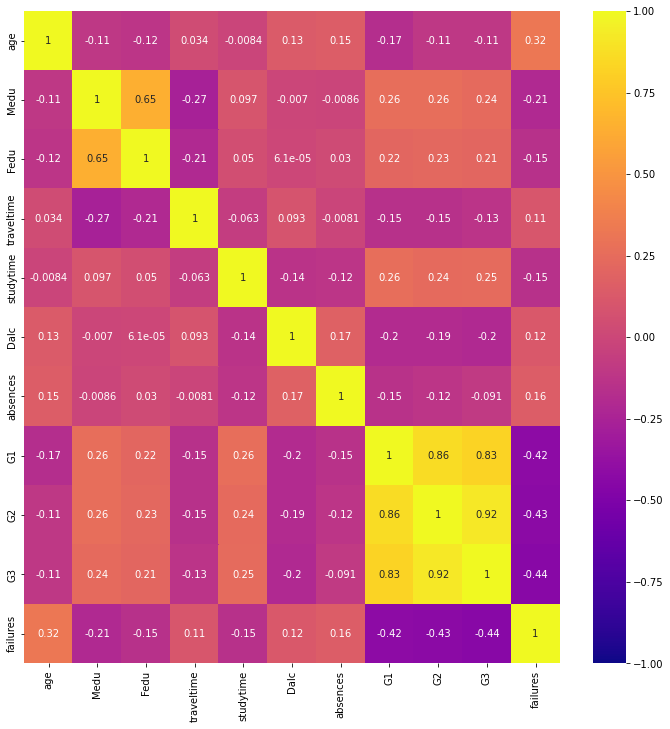

In [ ]:
fig = plt.figure(figsize=(12, 12))
corr_p = list(predictors.copy())
corr_p.append("failures")
sns.heatmap(df[list(corr_p)].corr(), vmin=-1, vmax=1, annot=True, cmap='plasma')

In [ ]:
x = pd.get_dummies(df[predictors], drop_first=True)
print(x.head())

   age  Medu  Fedu  traveltime  studytime  Dalc  absences  G1  G2  G3
0   18     4     4           2          2     1         4   0  11  11
1   17     1     1           1          2     1         2   9  11  11
2   15     1     1           1          2     2         6  12  13  12
3   15     4     2           1          3     1         0  14  14  14
4   16     3     3           1          2     1         0  11  13  13


In [ ]:
y = df["failures"]

In [ ]:
rand.seed(RAND)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=TEST_SIZE, stratify=y)

In [ ]:
def runModel(model, xt, yt, xv, yv):
    model.fit(xt, yt)
    y_pred = model.predict(xv)
    y_pred_prob = model.predict_proba(xv)[:, 1]
    print(y_pred_prob[0:10])  # first coloumn is prob of negative class (fail)
    labels = np.unique(yv)
    cm = confusion_matrix(yv, y_pred_prob > Y_PRED_PROB_THRESH, labels=labels)
    print(pd.DataFrame(cm, index=labels, columns=labels))
    print(f"{accuracy_score.__name__} : {accuracy_score(yv, y_pred_prob > Y_PRED_PROB_THRESH)}")
    for func in [recall_score, precision_score, f1_score]:
        print(f"{func.__name__} :  {func(yv, y_pred_prob > Y_PRED_PROB_THRESH, average = 'weighted')}")

    # print classification report
    print(metrics.classification_report(yv, y_pred))
    # calculate scores & Extracting probabilities
    auc = roc_auc_score(yv, pd.Series(model.predict_proba(xv)[:, 1]))
    # summarize scores
    print(f"ROC AUC : {auc:.3f}")
    plt.rcParams["figure.figsize"]=(10, 5)
    plt.figure()
    m_fpr, m_tpr, _ = roc_curve(yv, pd.Series(y_pred_prob))
    plt.plot(m_fpr, m_tpr, color="darkorange", lw=3)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig(f"{model}.png", dpi=150, bbox_inches="tight")

    # Cross-validation
    scores = cross_val_score(model, xt, yt, cv=CROSS_VAL_SPLIT, scoring="recall")
    print(f"cross validation : {scores}\nmean : {scores.mean()}")

    # Cross-validation splitter as a cv parameter
    shuffle_split = StratifiedShuffleSplit(
        #TEST_SIZE,
       #n_splits=CROSS_VAL_SPLIT,
        random_state=RAND,
    )
    scores = cross_val_score(model, xt, yt, cv=shuffle_split, scoring="recall")
    print(f"(shuffled-split) cross validation : {scores}\nmean : {scores.mean()}")

First Model: Decision Tree

[0.24731183 0.0152439  0.24731183 0.0152439  0.0152439  0.21428571
 0.0152439  0.0152439  0.0152439  0.54166667]
    0   1
0  86  24
1   4  16
accuracy_score : 0.7846153846153846
recall_score :  0.7846153846153846
precision_score :  0.8700854700854701
f1_score :  0.8097435897435897
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       110
           1       0.60      0.45      0.51        20

    accuracy                           0.87       130
   macro avg       0.75      0.70      0.72       130
weighted avg       0.86      0.87      0.86       130

ROC AUC : 0.800
cross validation : [0.5    0.0625 0.5    0.75   0.4375]
mean : 0.45
(shuffled-split) cross validation : [0.    0.75  0.    0.125 0.375 0.75  0.5   0.625 0.375 0.625]
mean : 0.4125


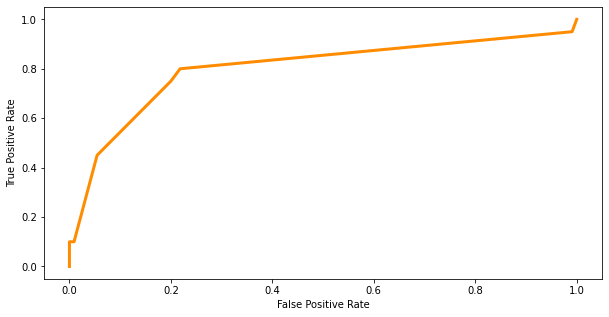

In [ ]:
# Decision Tree

d_tree = DecisionTreeClassifier(max_depth=3, random_state=RAND)
runModel(d_tree, x_train, y_train, x_val, y_val)

[0.87989556 0.05       0.64772727 0.05       0.05       0.45
 0.05       0.05       0.05       0.87989556]
    0   1
0  89  21
1   4  16
accuracy_score : 0.8076923076923077
recall_score :  0.8076923076923077
precision_score :  0.8762881988688441
f1_score :  0.8283174780452459
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       110
           1       0.47      0.75      0.58        20

    accuracy                           0.83       130
   macro avg       0.71      0.80      0.74       130
weighted avg       0.88      0.83      0.85       130

ROC AUC : 0.853
cross validation : [0.84090909 0.95454545 0.92045455 0.96551724 0.95454545]
mean : 0.9271943573667712
(shuffled-split) cross validation : [0.90909091 0.90909091 0.97727273 0.88636364 0.86363636 0.97727273
 0.81818182 0.90909091 0.90909091 0.88636364]
mean : 0.9045454545454545


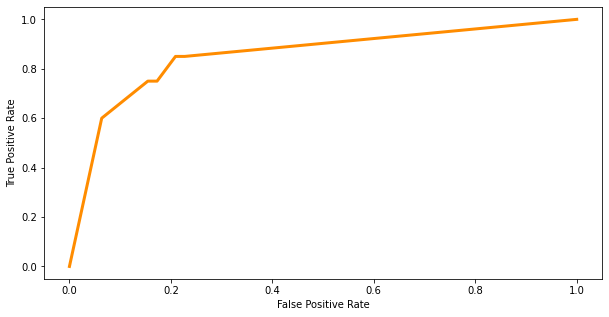

In [ ]:
# Decision Tree with SMOTE
sm = SMOTE(sampling_strategy="minority", random_state=RAND)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
d_tree = DecisionTreeClassifier(max_depth=3, random_state=RAND)
runModel(d_tree, x_train_res, y_train_res, x_val, y_val)

Second Model: Random Forest

[0.372 0.062 0.19  0.08  0.022 0.056 0.002 0.126 0.032 0.672]
    0   1
0  94  16
1   6  14
accuracy_score : 0.8307692307692308
recall_score :  0.8307692307692308
precision_score :  0.8671794871794871
f1_score :  0.8436630036630036
              precision    recall  f1-score   support

           0       0.89      0.98      0.94       110
           1       0.78      0.35      0.48        20

    accuracy                           0.88       130
   macro avg       0.84      0.67      0.71       130
weighted avg       0.87      0.88      0.87       130

ROC AUC : 0.862
cross validation : [0.4375 0.0625 0.3125 0.6875 0.25  ]
mean : 0.35
(shuffled-split) cross validation : [0.25  0.375 0.375 0.125 0.375 0.625 0.375 0.375 0.5   0.375]
mean : 0.375


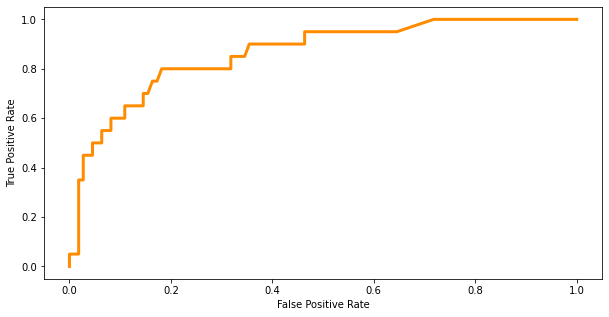

In [ ]:
# Random forest with no SMOTE

r_forest = RandomForestClassifier(n_estimators=500, random_state=RAND)
runModel(r_forest, x_train, y_train, x_val, y_val)

Plotting variable importance for Random Forest

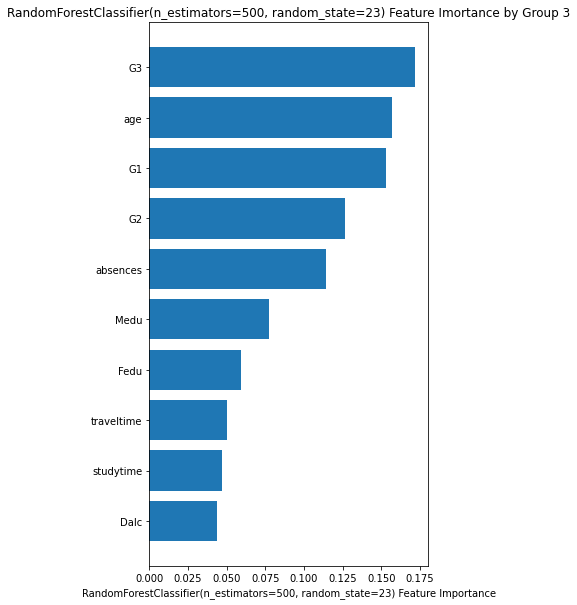

In [ ]:
plt.figure(figsize=(5, 10))
sorted_idx = r_forest.feature_importances_.argsort()
plt.barh(x.columns[0:][sorted_idx], r_forest.feature_importances_[sorted_idx])
plt.xlabel(f"{r_forest} Feature Importance")
plt.title(f"{r_forest} Feature Imortance by Group 3")
plt.savefig(f"{r_forest}_feature_importance.png", dpi=150, bbox_inches="tight")

Third Model: Random Forest with SMOTE undersampling

In [ ]:
sm = SMOTE(sampling_strategy="minority", random_state=RAND)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)

[0.49 0.11 0.29 0.06 0.07 0.04 0.   0.15 0.09 0.83]
    0   1
0  84  26
1   5  15
accuracy_score : 0.7615384615384615
recall_score :  0.7615384615384615
precision_score :  0.8549022914602524
f1_score :  0.7900029783216206
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       110
           1       0.50      0.40      0.44        20

    accuracy                           0.85       130
   macro avg       0.70      0.66      0.68       130
weighted avg       0.83      0.85      0.84       130

ROC AUC : 0.845
cross validation : [0.86363636 0.93181818 0.93181818 0.97701149 0.98863636]
mean : 0.9385841170323929
(shuffled-split) cross validation : [0.95454545 0.97727273 0.97727273 0.90909091 0.93181818 0.95454545
 0.90909091 0.97727273 0.95454545 0.95454545]
mean : 0.95


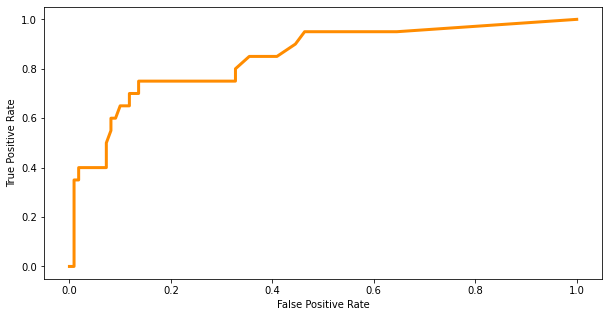

In [ ]:
# Random forest with SMOTE
RF = RandomForestClassifier(random_state=RAND)
runModel(RF, x_train_res, y_train_res, x_val, y_val)

Fourth Model: Logistic Regression

In [ ]:
# Drop all non-binary/continuous variables. 
# TODO: see if this can be automated.
df = pd.read_csv("student_por_mod.csv")
drop_cols = [col for col, cor in  df.select_dtypes([np.number]).corr().items()]
drop_cols.remove("failures")
df = df.drop(drop_cols, axis=1,)

Using train_test_split function to split the dataset

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=TEST_SIZE, stratify=y, random_state=RAND)

Chi Square test of Independence

In [ ]:
# Save all variables who's p-value from the chi-squre test is less than 0.05
significant_variables=[]
for col in df.columns[1:]:
    crosstab = pd.crosstab(df[col], df["failures"], margins=True)
    stat, p, dof, expected = chi2_contingency(crosstab)
    print("P value of Chi Square between failures and", col, "is", p)
    if p < .05 and not col == "failures":
      significant_variables.append(col)
print(significant_variables)

P value of Chi Square between failures and sex is 0.7681189589331214
P value of Chi Square between failures and address is 0.31903625373003225
P value of Chi Square between failures and famsize is 0.3848317164098338
P value of Chi Square between failures and Pstatus is 0.5842240156499936
P value of Chi Square between failures and Mjob is 0.49083824022501366
P value of Chi Square between failures and Fjob is 0.9329515861775366
P value of Chi Square between failures and reason is 0.05532513201245633
P value of Chi Square between failures and guardian is 1.731162840401958e-07
P value of Chi Square between failures and failures is 0.0
P value of Chi Square between failures and schoolsup is 0.9998179078186943
P value of Chi Square between failures and famsup is 0.9999834157485927
P value of Chi Square between failures and paid is 0.839873920060282
P value of Chi Square between failures and activities is 0.5425512268303463
P value of Chi Square between failures and nursery is 0.8731594141444

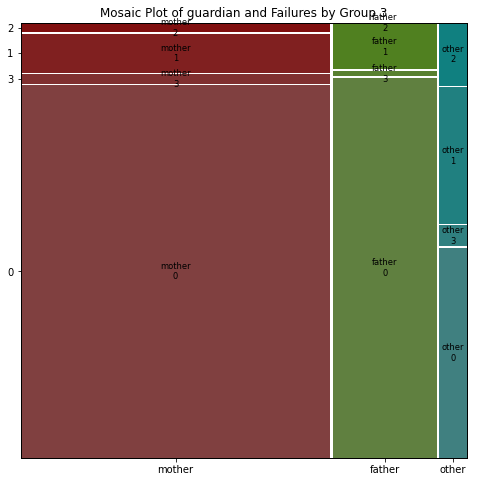

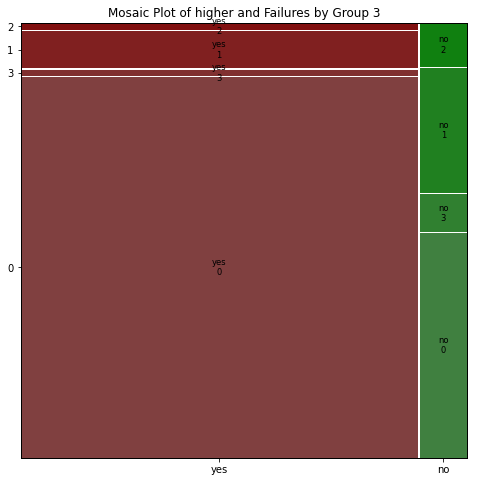

In [ ]:
# Print out a mosaic plot for each of our previously detected significant variables.
for sigvar in significant_variables:
  plt.rcParams["figure.figsize"]=(8, 8)
  mosaic(data=df, index=[sigvar, "failures"])
  plt.title(f"Mosaic Plot of {sigvar} and Failures by Group 3")

In [ ]:
print(df["failures"].value_counts())

0    549
1     70
2     16
3     14
Name: failures, dtype: int64


In [ ]:
predictors = pd.Index(significant_variables)

In [ ]:
x = pd.get_dummies(df[predictors], drop_first=True)
x.head()

,guardian_mother,guardian_other,higher_yes
0,1,0,1
1,0,0,1
2,1,0,1
3,1,0,1
4,0,0,1


[0.06057747 0.90122084 0.00525149 0.0012539  0.22965533 0.06325158
 0.11698723 0.07941342 0.05223666 0.0692682 ]
    0   1
0  92  18
1   6  14
accuracy_score : 0.8153846153846154
recall_score :  0.8153846153846154
precision_score :  0.8616562009419153
f1_score :  0.8313609467455622
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       110
           1       0.50      0.40      0.44        20

    accuracy                           0.85       130
   macro avg       0.70      0.66      0.68       130
weighted avg       0.83      0.85      0.84       130

ROC AUC : 0.816


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


cross validation : [0.3125 0.4375 0.625  0.375  0.4375]
mean : 0.4375
(shuffled-split) cross validation : [0.5   0.375 0.25  0.5   0.625 0.25  0.25  0.5   0.    1.   ]
mean : 0.425


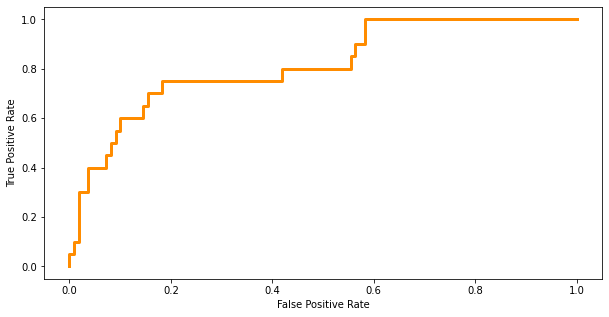

In [ ]:
# Logisitc Regression

lr_clf = LogisticRegression(random_state =RAND)
runModel(lr_clf, x_train, y_train, x_val, y_val)

[0.09095967 0.98572849 0.00827252 0.00192221 0.59078408 0.13696323
 0.25715752 0.52499019 0.46748342 0.22481767]
    0   1
0  63  47
1   3  17
accuracy_score : 0.6153846153846154
recall_score :  0.6153846153846154
precision_score :  0.8485576923076923
f1_score :  0.6680402930402931
              precision    recall  f1-score   support

           0       0.93      0.77      0.85       110
           1       0.36      0.70      0.47        20

    accuracy                           0.76       130
   macro avg       0.65      0.74      0.66       130
weighted avg       0.85      0.76      0.79       130

ROC AUC : 0.824


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


cross validation : [0.72727273 0.90909091 0.89772727 0.91954023 0.90909091]
mean : 0.8725444096133751
(shuffled-split) cross validation : [0.90909091 0.90909091 0.84090909 0.88636364 0.79545455 0.84090909
 0.90909091 0.90909091 0.81818182 0.86363636]
mean : 0.8681818181818182


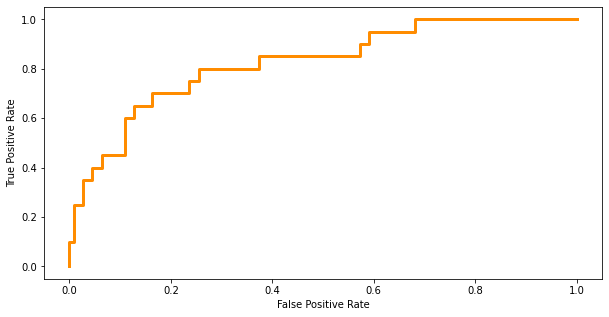

In [ ]:
# Logisitic regression with SMOTE

sm = SMOTE(sampling_strategy="minority", random_state=RAND)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
lr_clf = LogisticRegression(random_state=RAND)
runModel(lr_clf, x_train_res, y_train_res, x_val, y_val)

In [ ]:
# Logistic Regression model with SMOTE and KMeans. 
# Two clusters

sm = SMOTE(sampling_strategy="minority", random_state=RAND)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
kmeans = KMeans(n_clusters=2, random_state=RAND).fit(x_train_res, y_train_res)
x_train_res['kmeansGRP'] = kmeans.labels_
x_val_km = x_val.copy()
x_val_km['kmeansGRP'] = kmeans.predict(x_val)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[0.09766832 0.96782871 0.01588987 0.00218699 0.56131409 0.16506047
 0.24229344 0.45420471 0.31455137 0.24703151]
    0   1
0  61  49
1   3  17
accuracy_score : 0.6
recall_score :  0.6
precision_score :  0.8461174242424243
f1_score :  0.6541031809676557
              precision    recall  f1-score   support

           0       0.94      0.76      0.84       110
           1       0.37      0.75      0.49        20

    accuracy                           0.76       130
   macro avg       0.65      0.76      0.67       130
weighted avg       0.85      0.76      0.79       130

ROC AUC : 0.827


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

cross validation : [0.73863636 0.90909091 0.89772727 0.91954023 0.93181818]
mean : 0.8793625914315569


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

(shuffled-split) cross validation : [0.88636364 0.90909091 0.86363636 0.86363636 0.79545455 0.84090909
 0.93181818 0.95454545 0.81818182 0.88636364]
mean : 0.875


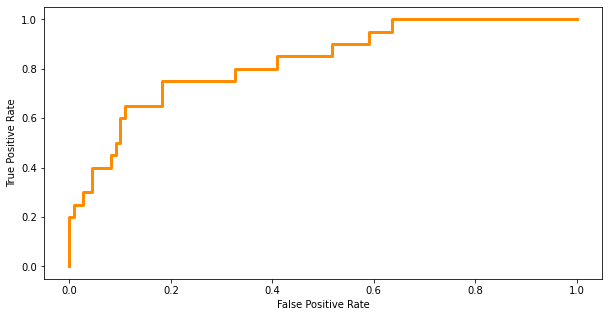

In [ ]:
lr_clf = LogisticRegression(solver='saga', random_state=RAND)
runModel(lr_clf, x_train_res, y_train_res, x_val_km, y_val)

In [ ]:
# Logistic Regression with just KMeans, and no SMOTE, also 2 clusters.

kmeans = KMeans(n_clusters=2, random_state=RAND).fit(x_train, y_train)
x_train['kmeansGRP'] = kmeans.labels_

x_val_km = x_val.copy()
x_val_km['kmeansGRP'] = kmeans.predict(x_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[0.03307638 0.94604616 0.00271763 0.00163496 0.3209935  0.03687802
 0.09303512 0.10106603 0.11365877 0.09029891]
    0   1
0  89  21
1   5  15
accuracy_score : 0.8
recall_score :  0.8
precision_score :  0.8652482269503545
f1_score :  0.8207282913165266
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       110
           1       0.56      0.45      0.50        20

    accuracy                           0.86       130
   macro avg       0.73      0.69      0.71       130
weighted avg       0.85      0.86      0.86       130

ROC AUC : 0.818


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter

cross validation : [0.3125 0.375  0.5625 0.4375 0.375 ]
mean : 0.4125
(shuffled-split) cross validation : [0.5   0.5   0.25  0.375 0.5   0.25  0.25  0.5   0.    0.75 ]
mean : 0.3875


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


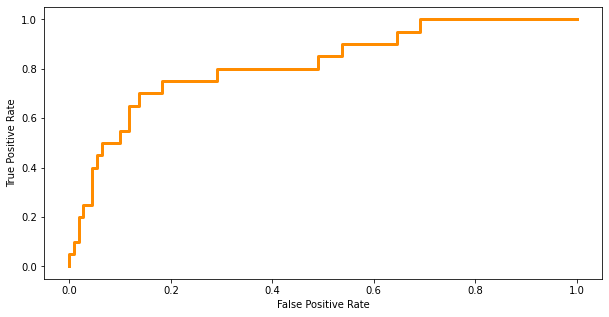

In [ ]:
lr_clf = LogisticRegression(solver='saga', random_state=RAND)
runModel(lr_clf, x_train, y_train, x_val_km, y_val)

# Testing

Code below is to test an alternative 
method of selecting our predictor variables.

In [ ]:
tdf = pd.read_csv('student_por_mod.csv')

tdf["failures"] = tdf["failures"].map({0: "no_fail", 1: "fail", 2: "fail", 3: "fail"})

tdf["failures"] = np.where(tdf.failures == "fail", 1, 0)
print(tdf.shape)

(649, 33)


In [ ]:
feat_num = tdf.shape[1] - 1
print(feat_num)
label_encoder = LabelEncoder()
tdf.iloc[:,feat_num] = label_encoder.fit_transform(tdf.iloc[:,feat_num]).astype('float64')
print(tdf)

32
    school sex  age address famsize  ... health  absences  G1  G2    G3
0       GP   F   18       U     GT3  ...      3         4   0  11   8.0
1       GP   F   17       U     GT3  ...      3         2   9  11   8.0
2       GP   F   15       U     LE3  ...      3         6  12  13   9.0
3       GP   F   15       U     GT3  ...      5         0  14  14  11.0
4       GP   F   16       U     GT3  ...      5         0  11  13  10.0
..     ...  ..  ...     ...     ...  ...    ...       ...  ..  ..   ...
644     MS   F   19       R     GT3  ...      5         4  10  11   7.0
645     MS   F   18       U     LE3  ...      1         4  15  15  13.0
646     MS   F   18       U     GT3  ...      5         6  11  12   6.0
647     MS   M   17       U     LE3  ...      2         6  10  10   7.0
648     MS   M   18       R     LE3  ...      5         4  10  11   8.0

[649 rows x 33 columns]


In [ ]:
tdf_t = pd.get_dummies(tdf, drop_first=True)
print(tdf_t)

     age  Medu  Fedu  ...  higher_yes  internet_yes  romantic_yes
0     18     4     4  ...           1             0             0
1     17     1     1  ...           1             1             0
2     15     1     1  ...           1             1             0
3     15     4     2  ...           1             1             1
4     16     3     3  ...           1             0             0
..   ...   ...   ...  ...         ...           ...           ...
644   19     2     3  ...           1             1             0
645   18     3     1  ...           1             1             0
646   18     1     1  ...           1             0             0
647   17     3     1  ...           1             1             0
648   18     3     2  ...           1             1             0

[649 rows x 42 columns]


In [ ]:
corr_matr = tdf_t.corr()

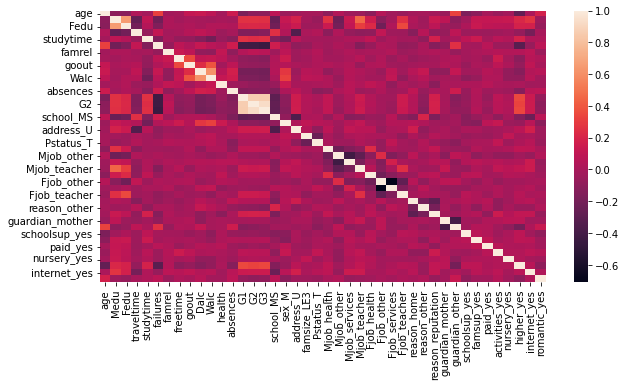

In [ ]:
sns.heatmap(corr_matr)

In [ ]:
cols = np.full((corr_matr.shape[0],), True, dtype=bool)
for i in range(corr_matr.shape[0]):
  for j in range(i+1, corr_matr.shape[0]):
    if corr_matr.iloc[i,j] >= 0.9:
      if cols[j]:
        cols[j] = False

selected_cols = tdf_t.columns[cols]

In [ ]:
tdf_t = tdf_t[selected_cols]
print(tdf_t)

     age  Medu  Fedu  ...  higher_yes  internet_yes  romantic_yes
0     18     4     4  ...           1             0             0
1     17     1     1  ...           1             1             0
2     15     1     1  ...           1             1             0
3     15     4     2  ...           1             1             1
4     16     3     3  ...           1             0             0
..   ...   ...   ...  ...         ...           ...           ...
644   19     2     3  ...           1             1             0
645   18     3     1  ...           1             1             0
646   18     1     1  ...           1             0             0
647   17     3     1  ...           1             1             0
648   18     3     2  ...           1             1             0

[649 rows x 41 columns]


In [ ]:
#selected_cols = tdf_t[1:].values
print(selected_cols)

Index(['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
       'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2',
       'school_MS', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T',
       'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher',
       'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher',
       'reason_home', 'reason_other', 'reason_reputation', 'guardian_mother',
       'guardian_other', 'schoolsup_yes', 'famsup_yes', 'paid_yes',
       'activities_yes', 'nursery_yes', 'higher_yes', 'internet_yes',
       'romantic_yes'],
      dtype='object')


In [ ]:
import statsmodels.formula.api as sm
import statsmodels.api as sm
def back_elim(x, Y, sl, cols):
  n_var = len(x[0])
  for i in range(0, n_var):
    regressor_OLS = sm.OLS(Y, x).fit()
    max_var = max(regressor_OLS.pvalues).astype(float)
    if max_var >= sl:
      for j in range(0, n_var - i):
        if (regressor_OLS.pvalues[j].astype(float) == max_var):
          x = np.delete(x, j, 1)
          cols = np.delete(cols, j)
  regressor_OLS.summary()
  return x, cols

In [ ]:
SL = 0.05
data_modeled, selected_cols = back_elim(tdf_t.iloc[:,1:].values, tdf_t.iloc[:,0].values, SL, selected_cols)

In [ ]:
result = pd.DataFrame()
result['failures'] = tdf_t.iloc[:,0]
print(result)

     failures
0          18
1          17
2          15
3          15
4          16
..        ...
644        19
645        18
646        18
647        17
648        18

[649 rows x 1 columns]


In [ ]:
selected_cols  = selected_cols.drop("failures")
ndf = pd.DataFrame(data = data_modeled, columns = selected_cols)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(ndf.values, result.values, test_size = 0.2)

In [ ]:
# Decision Tree

d_tree = DecisionTreeClassifier(max_depth=3, random_state=RAND)
runModel(d_tree, x_train, y_train, x_test, y_test)

[0.29562044 0.30909091 0.29562044 0.29562044 0.29562044 0.29562044
 0.29562044 0.29562044 0.30909091 0.30909091]
    15  16  17  18  19  20
15   0   0   0   0   0   0
16   0   0   0   0   0   0
17   0   0   0   0   0   0
18   0   0   0   0   0   0
19   0   0   0   0   0   0
20   0   0   0   0   0   0
accuracy_score : 0.0
recall_score :  0.0
precision_score :  0.0
f1_score :  0.0
              precision    recall  f1-score   support

          15       0.00      0.00      0.00        18
          16       0.29      0.40      0.34        35
          17       0.32      0.56      0.41        41
          18       0.18      0.07      0.10        29
          19       0.00      0.00      0.00         6
          20       0.00      0.00      0.00         1

    accuracy                           0.30       130
   macro avg       0.13      0.17      0.14       130
weighted avg       0.22      0.30      0.24       130



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarnin

ValueError: ignored